# 第三次课堂实验

在这次实验中，我们将尝试提取基本的图像特征并使用提取的特征进行图像分类。

你可以添加任意数量的 cell 来辅助你完成实验（方法：上方菜单栏 -> File -> Insert -> Insert Cell Above/Below）。

In [4]:
import random
import numpy as np
from data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (15., 12.) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 数据加载
数据集下载地址：http://camalab.hdu.edu.cn/dataset/cifar-10-python.tar

你需要把 CIFAR10 数据库放到指定的路径，或者直接修改代码中的路径。

In [5]:
def get_CIFAR10_data(num_training=5000, num_validation=500, num_test=500):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'cifar-10-batches-py' # cifar10 数据集的路径
    
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # 从数据集中采样
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print X_train.shape
print X_val.shape
print X_test.shape

(5000L, 32L, 32L, 3L)
(500L, 32L, 32L, 3L)
(500L, 32L, 32L, 3L)


## 提取图像特征
[方向梯度直方图 HOG (Histogram of Oriented Gridients)](http://blog.csdn.net/zouxy09/article/details/7929348)特征检测算法，最早是由法国研究员Dalal等在CVPR-2005上提出来的，一种解决人体目标检测的图像描述子，是一种用于表征图像局部梯度方向和梯度强度分布特性的描述符。其主要思想是：在边缘具体位置未知的情况下，边缘方向的分布也可以很好的表示图像中物体的外形轮廓，但会忽略掉颜色信息。

[颜色直方图 (color histogram)](https://baike.baidu.com/item/颜色直方图)特征则是提取图像的颜色信息并忽略掉纹理信息。因此同时使用这两种特征的分类效果会好于仅使用单一特征，__【加分项】你可以尝试进行对比实验验证这一假设__

`hog_feature` 和 `color_histogram_hsv` 两个函数都是接收一张图像然后返回这张图像的特征向量。你可以使用这两个函数中的一个提取所有图像的特征并将其存入 `X_train_feats, X_val_feats, X_test_feats` 这三个变量中（他们分别代表训练集、验证集和测试集的特征）。

In [9]:
from features import *

################################################################################
# TODO:                                                                        #
# 你需要使用 hog_feature, color_histogram_hsv 两个函数完成特征的提取                #
# 你可以在 features.py 中查看这两个函数的代码                                       #
################################################################################
nbins = 10 # Number of bins in the color histogram
#hog = hog_feature(img)
#hsv = color_histogram_hsv(img, nbins)
#feature_fns = [hog,hsv]
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################
# 预处理: 减去均值
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# 预处理: 除以标准差，这能保证所有的值在 0～1 之间
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# 预处理: 增加一个偏置值，在 K-NN 中，该步操作并无必要，但增加偏置值对其他分类器如 SVM 等有帮助。
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 5000 images
Done extracting features for 2000 / 5000 images
Done extracting features for 3000 / 5000 images
Done extracting features for 4000 / 5000 images


### 特征可视化
如果你是提取的颜色直方图特征，可以使用 `plt.hist(X_train[0:4])` 可视化，如果提取的是 HOG 特征，你可以使用 `plt.imshow(X_train[0])` 可视化。

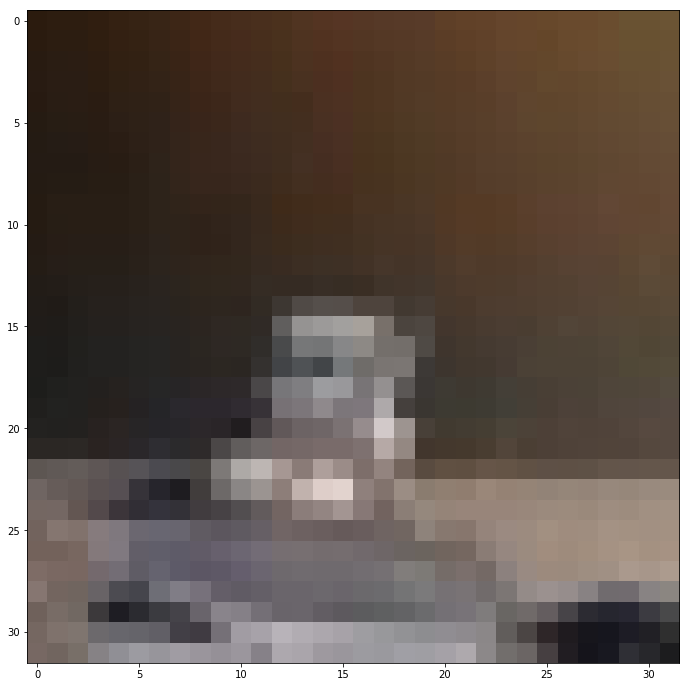

In [13]:
# 你的代码
plt.imshow(X_train[100])

## 使用 k-NN 算法对图像进行分类

使用上面提取的特征执行 k-NN 算法对图像分类，在这里，__【加分项】你也可以实验使用 HOG／颜色直方图特征与使用图像原始特征（像素）哪个好__。

这里你需要

如果你遇到了错误 `ImportError: No module named past.builtins`，可以在命令行工具中执行 `pip install future`

你可能需要认真阅读玩下面两篇文章后才能完成这部分作业：

- [CS231n课程笔记翻译：图像分类笔记（上）](https://zhuanlan.zhihu.com/p/20894041?refer=intelligentunit)
- [CS231n课程笔记翻译：图像分类笔记（下）](https://zhuanlan.zhihu.com/p/20900216?refer=intelligentunit)

In [29]:
from k_nearest_neighbor import KNearestNeighbor

classifier = KNearestNeighbor()
classifier.train(X_train_feats, y_train)

In [36]:
# 使用验证集调整 k 的值

k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]
k_to_accuracies = {} # your should store the results in this dict

################################################################################
# TODO:                                                                        #
# 你需要从 k_choice 中找出最好的 k                                                #
#                                                                              #
################################################################################
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

dists = classifier.compute_distances_two_loops(X_test)
#for k in k_choices:
y_test_pred = classifier.predict_labels(dists, 1)
num_correct = np.sum(y_test_pred == y_test)
k_to_accuracies = float(num_correct) / num_test
#print 'Got %d/%d  correct => accuracy: %f' % (num_correct,num_test, k_to_accuracies)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

for k in sorted(k_to_accuracies):
    print 'k = %d, accuracy = %f' % (k, k_to_accuracies[k])

TypeError: 'float' object is not iterable

In [37]:
# 评估你的算法

best_k = 5  # 填你上面选出的 K 值

# 计算测试集上准确率
y_test_pred = classifier.predict(X_test_feats, k=best_k)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.114


In [ ]:
#还没解决，未完待续……